# Zadatak 1
#### Marko Šišović, 2024/3104

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

Učitajmo najpre podatke iz .csv datoteke. Podelićemo date podatke na matricu $x$, koja predstavlja matricu prediktora, kao i vektor $y$, koji predstavlja vektor ciljne promenljive. Dodatno, nasumično ćemo promešati date podatke, kao i podeliti ih na trening i test skup, u odnosu $80:20$. Na kraju koda ispisujemo dimenzionalnosti prethodno pomenutih elemenata, kako bismo se uverili u njihovo poklapanje.

In [3]:
data = np.loadtxt("../data-reg.csv", delimiter=",")
x, y = data[:, :-1], data[:, -1]

split_ratio = 0.8

split_index = int(len(x) * split_ratio)

indices = np.random.permutation(len(x))
x, y = x[indices], y[indices]

x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(273, 5) (273,) (69, 5) (69,)


Pošto je zbir cifara indeksa $S = 3 + 1 + 0 + 4 = 8$, pa je $S\mod 3 = 8 \mod 3 = 2$, i stoga rešavamo problem korišćenjem lokalno ponderisane linearne regresije. Kako bismo nasli parametre $\theta$ za svaki uzorak koristićemo istu formulu za analitičko rešenje kao i kod obične linearne regresije, samo što ćemo umesto matrice $X$ i vektora $y$, koristiti elemente korigovane odgovarajućim težinama, $X_w$ i $y_w$.

Hiperparametar $\tau$ biramo pomoću unakrsne validacije. Parametar $k$ za unakrsnu validaciju iznosi $5$.

In [4]:
def calculate_weight(x_star, x, tau):
    return np.exp(-np.linalg.norm(x_star - x)**2/(2*tau**2))

def estimate_y(x_star, tau, x, y):
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x = (x - x_mean)/x_std
    x_star = (x_star - x_mean)/x_std

    x = np.hstack((np.ones((x.shape[0], 1)), x))
    x_star = np.insert(x_star, 0, 1)

    y = y[:, np.newaxis]

    w = np.apply_along_axis(lambda row: calculate_weight(x_star, row, tau), axis = 1, arr = x)
    w = w[:, np.newaxis]
    w_sqrt = np.sqrt(w)
    xw, yw = x*w_sqrt, y*w_sqrt

    theta = np.linalg.inv(xw.T@xw)@xw.T@yw

    y_est = theta.T@x_star
    return y_est

def estimate_error(tau, k = 5):
    fold_size = len(x_train) // k
    err_vector = np.array([])
    for fold in range(k):
        val_start = fold * fold_size
        val_end = val_start + fold_size if fold < k - 1 else len(x_train)
        
        x_val_fold = x_train[val_start:val_end]
        y_val_fold = y_train[val_start:val_end]
        
        x_train_fold = np.concatenate((x_train[:val_start], x_train[val_end:]), axis=0)
        y_train_fold = np.concatenate((y_train[:val_start], y_train[val_end:]), axis=0)
        
        y_val_fold_est = np.apply_along_axis(lambda row: estimate_y(row, tau, x_train_fold, y_train_fold), axis = 1, arr = x_val_fold)
        err = np.linalg.norm(y_val_fold_est - y_val_fold[:, np.newaxis])**2
        err_vector = np.append(err_vector, err)
    return np.mean(err_vector)

tau_arr = np.linspace(0.5, 20, 50)
estimate_error_vectorized = np.vectorize(lambda tau: estimate_error(tau))
err_arr = estimate_error_vectorized(tau_arr)

In [5]:
min_index = np.argmin(err_arr)
tau_opt = tau_arr[min_index]
err_opt = err_arr[min_index]
print("Optimalna vrednost hiperparametra tau:", tau_opt, sep = ' ')

Optimalna vrednost hiperparametra tau: 3.683673469387755


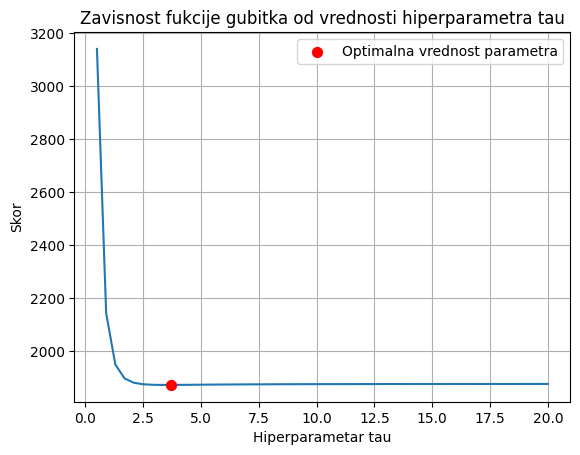

In [6]:
plt.plot(tau_arr, err_arr)

plt.xlabel('Hiperparametar tau')
plt.ylabel('Skor')
plt.title('Zavisnost fukcije gubitka od vrednosti hiperparametra tau')

plt.scatter(tau_opt, err_opt, color='red', s=50, label=f"Optimalna vrednost parametra", zorder=5)

plt.grid(True)

plt.legend()
plt.show()

Na grafiku iznad možemo videti kako se menja skor određen pomoću unakrsne validacije sa promenom hiperparametra. Takođe, očitavamo optimalnu vrednost $\tau$. Kako su performanse pri unakrsnoj validaciji slične za optimalno tau, kao i za velike tau, zaključujemo da bi i obična linearna regresija verovatno radila posao sa sličnom greškom.

Za kraj, procenićemo srednju kvadratnu grešku na test skupu:

In [7]:
y_test_est = np.apply_along_axis(lambda row: estimate_y(row, tau_opt, x_train, y_train), axis = 1, arr = x_test)
err_est = np.linalg.norm(y_test_est - y_test[:, np.newaxis])**2/y_test.shape[0]
print("Estimacija korena srednje kvadratne greške na test skupu: ", np.sqrt(err_est), sep = "")

Estimacija korena srednje kvadratne greške na test skupu: 5.264982555356493


## Poređenje sa LASSO regresijom

Za potrebe proveravanja prethodno dobijenih rezultata, implementiran je LASSO klasifikator pomoću gotovih biblioteka. Optimalna vrednost regularizacionog parametra takođe je određena unakrsnom validacijom.

In [8]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [9]:
poly = PolynomialFeatures(degree=2, include_bias=True)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

alpha_values = np.logspace(-4, 1, 50)
lasso = Lasso()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train_poly, y_train)

best_alpha = grid_search.best_params_['alpha']
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(x_train_poly, y_train)

y_train_pred = lasso_best.predict(x_train_poly)
mse_train = mean_squared_error(y_train, y_train_pred)

print("Optimalno alfa:", best_alpha)
print("Srednje kvadratna greška na trening skupu za optimalno alfa:", mse_train)


Optimalno alfa: 0.7543120063354622
Srednje kvadratna greška na trening skupu za optimalno alfa: 29.66687998903571


In [10]:
y_test_pred = lasso_best.predict(x_test_poly)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Estimacija korena srednje kvadratne greške na test skupu: ", np.sqrt(mse_test))

Estimacija korena srednje kvadratne greške na test skupu:  5.433178699365321


Vidimo da su srednje kvadratne greške gotovo iste kao i za lokalno ponderisanu linearnu regresiju, što ukazuje na ispravnost obe implementacije.